Beal, L.D.R., Hill, D., Martin, R.A., and Hedengren, J. D., GEKKO Optimization Suite, Processes, Volume 6, Number 8, 2018, doi: 10.3390/pr6080106.

In [1]:
from gekko import GEKKO
import numpy as np
from numpy.random import seed
from numpy.random import randint
from math import sqrt
import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [2]:
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 50000', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 5000', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 5000', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 2', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.00005', \
                    # covergence tolerance
                    'minlp_gap_tol 0.0001']


In [3]:
# Input 1 - Solution Found with TT
xs = [-222, 37, -252, -239, -145, -197, -243, -104, 81, -159, 68, 101, -229]
ys = [234, 171, 49, 225, -121, 221, 21, 74, -199, -180, 229, 142, -201]

rs = [5, 4, 5, 3, 4, 4, 2, 3, 2, 2, 5, 4, 5]


# Input 2 - Solution Found with TT
xs = [152, 116, -139, 52, 173, -25, 132, 6, -150, 24, 121, -87, -128]
ys = [-193, 169, -46, -28, -70, -59, 196, -178, 15, -12, 33, 93, -5]
rs = [2, 3, 4, 2, 3, 4, 2, 3, 4, 4, 4, 2, 4]


# Input 3
#xs = [155, 181, -173, -133, 140, 113, -227, 211, 216, -260, 94, -19, -222]
#ys = [-101, 227, 0, 4, -7, -81, 61, 73, -255, -201, 235, -188, 257]
#rs = [4, 2, 3, 5, 2, 2, 2, 3, 3, 5, 4, 5, 3]
n = 13

In [4]:
# Integer constraints - Can be 0 (not connected) or 1 (connected)

tot = n*(n-1)

# Connected or not
c = []
for i in range(n):
    c.append([0] * n)
        
for i in range(n):
    for j in range(n):
        
        if (i==j):
            c[i][j] = 0   
        elif (j==i+1) :       
            c[i][j] = m.Var(value=1, lb=0, ub=1, integer=True) 
        elif (j==0)&(i==n-1):       
            c[i][j] = m.Var(value=1, lb=0, ub=1, integer=True) 
        else:
            c[i][j] = m.Var(value=0, lb=0, ub=1, integer=True) 
            

# Real Value constraints - Center of Nodes 
# X-Coorindates
x = [m.Var(value=xs[i], lb=xs[i]-rs[i], ub=xs[i]+rs[i]) for i in range(n)]
# Y-Coorindates
y = [m.Var(value=ys[i], lb=ys[i]-rs[i], ub=ys[i]+rs[i]) for i in range(n)]


#print(x)
#print(y)
print(c)



[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [5]:
### Objective Function
objective_test = 0
indices_array = list(range(0, n))
#print(indices_array)
for i in range(n):    
    for j in range(n):
        dist = m.Intermediate((x[i] - x[j])*(x[i] - x[j]) + (y[i] - y[j])*(y[i] - y[j]))
        objective_test = objective_test + m.Intermediate(m.sqrt(dist)*c[i][j])
        
#print(objective_test)

### Constraint Equations/Inequations

# xij
# Node i can go to only one j (i != j)
for i in range(n):
    eq = 0
    for j in range(n):
        eq  = eq + c[i][j]
    m.Equation(eq == 1)

# xij
# Node j can go to only one i (j != i)
for i in range(n):
    eq = 0
    for j in range(n):
        eq  = eq + c[j][i]
    m.Equation(eq == 1)


# Neighborhood Constraint                   
for i in range(n):
    left_term = (x[i] - xs[i])*(x[i] - xs[i]) + (y[i] - ys[i])*(y[i] - ys[i])
    right_term = rs[i]*rs[i]                
    m.Equation(left_term <= right_term)
                   

In [6]:
def compare_if_lists_same(list1, list2):
    rows = len(list1)
    columns = len(list1[0])
    count = 0
    for i in range(rows):
        for j in range(columns):
            if list1[i][j] != list2[i][j]:
                count = count + 1
            else:
                count = count
    if count == 0:
        return(True)
    else:
        return(False)
                
            

In [7]:
def TRUST_TECH_x(x, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, ii_change, n):    
    i = 0
    x_new = x
    c = cost_prev
    tol = 1
    while (tol >= 0) & (i <= 20):
        x_new = x_new + step_size*direction        
        xv_copy[ii_change] = x_new
        
        cost_curr = compute_cost(xv_copy, yv_copy, cv_copy, n)
        #print(i)
        #print(cost_curr)
        tol = cost_curr - cost_prev
        cost_prev = cost_curr
        i = i + 1
    if (tol >= 0):
        x_new = x
        cost_curr = c
        
    return x_new, cost_curr
    

In [8]:
def TRUST_TECH_y(y, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, ii_change, n):    
    i = 0
    y_new = y
    c = cost_prev
    tol = 1
    while (tol >= 0) & (i <= 20):
        y_new = y_new + step_size*direction        
        yv_copy[ii_change] = y_new        
        cost_curr = compute_cost(xv_copy, yv_copy, cv_copy, n)
        tol = cost_curr - cost_prev
        cost_prev = cost_curr
        i = i + 1
    if (tol >= 0):
        y_new = y
        cost_curr = c        
    return y_new, cost_curr

In [9]:
import math

def compute_cost(xv_copy, yv_copy, cv_copy, n):
    cost_curr = 0
    for ii in range(n):
            for jj in range(n):
                dist = (xv_copy[ii] - xv_copy[jj])*(xv_copy[ii] - xv_copy[jj]) + (yv_copy[ii] - yv_copy[jj])*(yv_copy[ii] - yv_copy[jj])
                cost_curr = cost_curr + (math.sqrt(dist)*cv_copy[ii][jj])
    return cost_curr

In [10]:
# Solving
#f = objective_vars
import time
n_components = n
cv_prev = []
for i in range(n):
    cv_prev.append([0] * n)
step_size = n/10.0
direction = 1
tol = 0.1
start_time = time.time()

while (n_components > 1):
    m.Obj(objective_test) # Objective
    m.solve(disp=True) # Solve
    
    # Reading Output Values from the Solver
    xv = [0] * n
    for i in range(n):
        xv[i] = x[i][0]

    yv = [0] * n
    for i in range(n):
        yv[i] = y[i][0]

    cv = []
    for i in range(n):
        cv.append([0] * n)
        
    for i in range(n):
        for j in range(n):
            if (i != j) :       
                cv[i][j] = c[i][j][0] 
            else:
                cv[i][j] = 0 
   
    result = compare_if_lists_same(cv_prev, cv)
    print(result)
    
    if result == False:
        # Checking Number of Connected Components in Graph
        graph = cv.copy()
        graph = csr_matrix(graph)
        n_components, labels = connected_components(csgraph=graph, directed=True, return_labels=True)
        print(n_components)
        if n_components > 1:

            # Creating a List of Connected Components
            connected_components_list = []
            label_range = list(range(n_components))
            for i in range(n_components):
                label_value = label_range[i]
                connected_components_list_element = []
                for j in range(n):
                    if label_value == labels[j]:
                        ele = j+1
                        connected_components_list_element.append(ele)
                connected_components_list.append(connected_components_list_element)
            
            # Add Constraints
            for i in range(n_components):
                connected_components_list_element = connected_components_list[i]
                len_conn = len(connected_components_list_element)
                right_term = len_conn - 1
                left_term = 0
                if len_conn == 2:
                    ele1 = connected_components_list_element[0] - 1  
                    ele2 = connected_components_list_element[1] - 1  
                    left_term = left_term + c[ele1][ele2] + c[ele2][ele1]
                else:
                    for j in range(0, len_conn):                          
                        ele1 = connected_components_list_element[j] - 1  
                        for k in range(n):
                            if cv[ele1][k] == 1:
                                ele2 = k 
                        left_term = left_term + c[ele1][ele2] 
                     
                m.Equation(left_term <= right_term)
               
            
            
            xv_copy = xv.copy()
            yv_copy = yv.copy()
            cv_copy = cv.copy() 
            cost_prev = compute_cost(xv_copy, yv_copy, cv_copy, n)   
            found = 0
            i_loop = 0
            x_new_array = []
            x_new_or_not = []
            cost_array_x = []
            y_new_array = []
            y_new_or_not = []
            cost_array_y = []
            for i_loop in range(n):                
                x_check = x[i_loop][0]
                y_check = y[i_loop][0]
                x_new, cost_new_x = TRUST_TECH_x(x_check, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, i_loop, n)
                y_new, cost_new_y = TRUST_TECH_y(y_check, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, i_loop, n)
                if x_new != x_check:
                    x_new_or_not.append(1)
                else:
                    x_new_or_not.append(0)
                if y_new != y_check:
                    y_new_or_not.append(1)
                else:
                    y_new_or_not.append(0)
                x_new_array.append(x_new)
                y_new_array.append(y_new)
                cost_array_x.append(cost_new_x)
                cost_array_y.append(cost_new_y)
                

            for i in range(n):
                if x_new_or_not[i] == 1:
                    x[i][0] = x_new_array[i]
                    
            for i in range(n):
                if y_new_or_not[i] == 1:
                    y[i][0] = y_new_array[i]

    else:
        print('Solution is Stuck')
        n_components = 1
        
                     
    cv_prev = cv.copy()
print("--- %s seconds ---" % (time.time() - start_time))

apm 104.167.146.65_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          195
   Intermediates:          338
   Connections  :            0
   Equations    :          378
   Residuals    :           40
 
 Number of state variables:            195
 Number of total equations: -           39
 Number of slack variables: -           13
 ---------------------------------------
 Degrees of freedom       :            143
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.10 NLPi:   25 Dpth:    0 Lvs:    3 Obj:  9.78E+02 Gap:       NaN
--Integer Solution:   9.78E+02 Lowest

False
2
apm 104.167.146.65_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          211
   Intermediates:          338
   Connections  :            0
   Equations    :          398
   Residuals    :           60
 
 Number of state variables:            211
 Number of total equations: -           55
 Number of slack variables: -           29
 ---------------------------------------
 Degrees of freedom       :            127
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.18 NLPi:   20 Dpth:    0 Lvs:    3 Obj:  6.09E+03 Gap:       NaN
Iter:     2 I: -1 Tm:      0.

Iter:     6 I: -1 Tm:      0.10 NLPi:    9 Dpth:    2 Lvs:    4 Obj:  7.32E+03 Gap:       NaN
Iter:     7 I:  0 Tm:      0.09 NLPi:    9 Dpth:    2 Lvs:    6 Obj:  7.45E+03 Gap:       NaN
Iter:     8 I: -1 Tm:      0.14 NLPi:   14 Dpth:    3 Lvs:    5 Obj:  7.45E+03 Gap:       NaN
Iter:     9 I:  0 Tm:      0.10 NLPi:   10 Dpth:    2 Lvs:    7 Obj:  7.72E+03 Gap:       NaN
Iter:    10 I: -1 Tm:      0.09 NLPi:    8 Dpth:    3 Lvs:    6 Obj:  7.72E+03 Gap:       NaN
Iter:    11 I:  0 Tm:      0.16 NLPi:   16 Dpth:    2 Lvs:    8 Obj:  7.70E+03 Gap:       NaN
Iter:    12 I: -1 Tm:      0.12 NLPi:   11 Dpth:    3 Lvs:    7 Obj:  7.70E+03 Gap:       NaN
Iter:    13 I:  0 Tm:      0.09 NLPi:    9 Dpth:    2 Lvs:    9 Obj:  7.70E+03 Gap:       NaN
Iter:    14 I: -1 Tm:      0.10 NLPi:    9 Dpth:    3 Lvs:    8 Obj:  7.70E+03 Gap:       NaN
Iter:    15 I:  0 Tm:      0.07 NLPi:    7 Dpth:    3 Lvs:   10 Obj:  7.46E+03 Gap:       NaN
Iter:    16 I: -1 Tm:      0.09 NLPi:    8 Dpth:    4 Lvs:  

Iter:     2 I: -1 Tm:      0.60 NLPi:   55 Dpth:    1 Lvs:    2 Obj:  8.52E+03 Gap:       NaN
Iter:     3 I: -1 Tm:      0.14 NLPi:   13 Dpth:    1 Lvs:    1 Obj:  8.52E+03 Gap:       NaN
Iter:     4 I:  0 Tm:      0.18 NLPi:   16 Dpth:    1 Lvs:    3 Obj:  8.53E+03 Gap:       NaN
Iter:     5 I: -1 Tm:      0.11 NLPi:    9 Dpth:    2 Lvs:    2 Obj:  8.53E+03 Gap:       NaN
Iter:     6 I:  0 Tm:      0.14 NLPi:   13 Dpth:    2 Lvs:    4 Obj:  8.69E+03 Gap:       NaN
Iter:     7 I: -1 Tm:      0.12 NLPi:   10 Dpth:    3 Lvs:    3 Obj:  8.69E+03 Gap:       NaN
Iter:     8 I: -1 Tm:      0.10 NLPi:    9 Dpth:    2 Lvs:    2 Obj:  8.53E+03 Gap:       NaN
Iter:     9 I:  0 Tm:      0.13 NLPi:   12 Dpth:    3 Lvs:    4 Obj:  8.71E+03 Gap:       NaN
Iter:    10 I: -1 Tm:      0.15 NLPi:   13 Dpth:    4 Lvs:    3 Obj:  8.71E+03 Gap:       NaN
Iter:    11 I:  0 Tm:      0.13 NLPi:   12 Dpth:    3 Lvs:    5 Obj:  8.72E+03 Gap:       NaN
Iter:    12 I: -1 Tm:      0.14 NLPi:   12 Dpth:    4 Lvs:  

Iter:    35 I: -1 Tm:      0.20 NLPi:   16 Dpth:    6 Lvs:   13 Obj:  1.06E+04 Gap:       NaN
--Integer Solution:   1.08E+04 Lowest Leaf:   1.05E+04 Gap:   2.84E-02
Iter:    36 I:  0 Tm:      0.30 NLPi:   25 Dpth:    5 Lvs:   12 Obj:  1.08E+04 Gap:  2.84E-02
Iter:    37 I:  0 Tm:      0.24 NLPi:   20 Dpth:    5 Lvs:   14 Obj:  1.06E+04 Gap:  2.84E-02
Iter:    38 I: -1 Tm:      0.15 NLPi:   12 Dpth:    6 Lvs:   13 Obj:  1.06E+04 Gap:  2.84E-02
Iter:    39 I:  0 Tm:      0.15 NLPi:   13 Dpth:    5 Lvs:   12 Obj:  1.10E+04 Gap:  2.84E-02
Iter:    40 I:  0 Tm:      0.16 NLPi:   13 Dpth:    6 Lvs:   14 Obj:  1.07E+04 Gap:  2.84E-02
Iter:    41 I: -1 Tm:      0.20 NLPi:   16 Dpth:    7 Lvs:   13 Obj:  1.07E+04 Gap:  2.84E-02
Iter:    42 I:  0 Tm:      0.19 NLPi:   16 Dpth:    6 Lvs:   12 Obj:  1.08E+04 Gap:  2.84E-02
Iter:    43 I:  0 Tm:      0.15 NLPi:   13 Dpth:    6 Lvs:   14 Obj:  1.06E+04 Gap:  2.84E-02
Iter:    44 I: -1 Tm:      0.20 NLPi:   16 Dpth:    7 Lvs:   13 Obj:  1.06E+04 Gap:

In [11]:
print('Results')
print(x)
print(y)
for i in range(n):
    print(c[i])

print('Objective: ' + str(m.options.objfcnval))

Results
[[150.78275656], [118.93710228], [-138.56666241], [52.856468302], [170.39516005], [-28.080047734], [130.61552532], [7.9037703287], [-146.1384658], [27.999464369], [117.57351351], [-85.751405136], [-126.57106716]]
[[-191.41304029], [168.38824807], [-42.023527911], [-26.192664296], [-71.488241854], [-61.552117951], [194.5565565], [-175.68145336], [13.956662271], [-12.065490527], [35.063934678], [91.437614601], [-8.7360640935]]
[0, [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], 0, [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0]]
[[0.0], [0.0], 0, [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], 0, [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[1.0], [0.0], [0.0], [0.0], 0, [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], 0, [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0]]
[[0.0], [1.0], [0.0], [0.0], [0.0],

In [12]:
# Reading Output Values from the Solver for Plotting
import networkx as nx

xv = [0] * n
for i in range(n):
    xv[i] = x[i][0]

yv = [0] * n
for i in range(n): 
    yv[i] = y[i][0]

cv = []
for i in range(n):
    cv.append([0] * n)
for i in range(n):
    for j in range(n):
        if (i != j) :       
            cv[i][j] = c[i][j][0] 
        else:
            cv[i][j] = 0 
            
graph_xs = []
graph_ys = []  
graph = cv.copy()
A = np.array(graph)

pos_dict = {}
nodess = range(0, n)
keyss = xv.copy()
valuess = yv.copy()


a = []
for i in range (n):
    a.append((keyss[i], valuess[i]))
a = tuple(a)  


pos_dict = dict(zip(nodess, a))
print(pos_dict)
H = nx.from_numpy_matrix(A)


{0: (150.78275656, -191.41304029), 1: (118.93710228, 168.38824807), 2: (-138.56666241, -42.023527911), 3: (52.856468302, -26.192664296), 4: (170.39516005, -71.488241854), 5: (-28.080047734, -61.552117951), 6: (130.61552532, 194.5565565), 7: (7.9037703287, -175.68145336), 8: (-146.1384658, 13.956662271), 9: (27.999464369, -12.065490527), 10: (117.57351351, 35.063934678), 11: (-85.751405136, 91.437614601), 12: (-126.57106716, -8.7360640935)}


C:\Users\Samhita\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


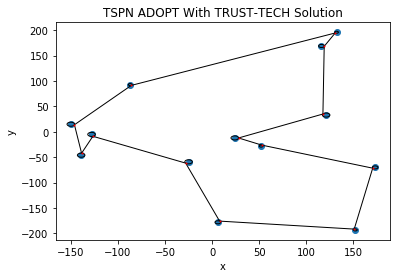

In [13]:

plt.scatter(xs, ys)
#plt.plot(graph_xs, graph_ys)
circles = []
for i in range(n):
    circle_i = plt.Circle((xs[i], ys[i]), rs[i], fill=False)
    circles.append(circle_i)

plt.title('TSPN ADOPT With TRUST-TECH Solution')


# fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
fig = plt.gcf()
ax = fig.gca()

for i in range(n):    
    ax.add_artist(circles[i])
    
nx.draw(H, pos_dict, ax, node_size=1)
plt.xlabel('x')
plt.ylabel('y')
limits = plt.axis('on')
plt.draw()

fig.savefig('plotcircles_functions_13Nodes_TT_BB2.png')